In [122]:
import pandas as pd
import numpy as np
import jenkspy
from lifelines import KaplanMeierFitter
from scipy.special import expit
from itertools import combinations
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

In [123]:
df = pd.read_excel("D:/MCM/initial_data/nipt_data.xlsx", sheet_name="男胎检测数据")
df = df[df['Y染色体浓度'].notna()].copy()

def convert_ga_to_decimal(ga_str, error_list):
    if pd.isna(ga_str):
        error_list.append(ga_str)
        return np.nan
    ga_str = str(ga_str).lower().replace(' ', '')
    if ga_str.endswith('w') and ga_str[:-1].isdigit():
        return float(ga_str[:-1])
    for sep in ['w+', 'w', '+']:
        if sep in ga_str:
            parts = ga_str.split(sep)
            if len(parts) == 2:
                try:
                    return int(parts[0]) + int(parts[1]) / 7.0
                except ValueError:
                    error_list.append(ga_str)
                    return np.nan
    error_list.append(ga_str)
    return np.nan

error_list = []
df['小数孕周'] = df['检测孕周'].apply(lambda x: convert_ga_to_decimal(x, error_list))
# df = df[(df['小数孕周'] >= 10) & (df['小数孕周'] <= 25)]
# df['GC含量_百分比'] = df['GC含量'] * 100
# df = df[(df['GC含量_百分比'] >= 40) & (df['GC含量_百分比'] <= 60)]

df['Y染色体浓度_百分比'] = df['Y染色体浓度'] * 100
df = df[(df['Y染色体浓度_百分比'] >= 0) & (df['Y染色体浓度_百分比'] <= 15)]

df['IVF妊娠'] = df['IVF妊娠'].replace({
    '自然受孕': 0,
    'IUI（人工授精）': 1,
    'IVF（试管婴儿）': 2 
})

category_mapping = {
    "1": 1, 
    "2": 2, 
    "≥3": 3,
    1: 1,
    2: 2
}
df["怀孕次数_类型"] = df["怀孕次数"].map(category_mapping)

unmapped_values = set(df['怀孕次数'].unique()) - set(category_mapping.keys())
print("未映射的'怀孕次数'值：", unmapped_values)

未映射的'怀孕次数'值： set()


C:\Users\xia\AppData\Local\Temp\ipykernel_32956\3068463494.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IVF妊娠'] = df['IVF妊娠'].replace({


In [124]:
grouped_df = df.groupby('孕妇代码').agg({
    '身高': list,
    '体重': list,
    '年龄': list,
    '孕妇BMI': list,
    'IVF妊娠': list,
    '怀孕次数_类型': list,
    'Y染色体浓度_百分比': list,
    '小数孕周': list
}).reset_index()
print(grouped_df)

     孕妇代码                                          身高  \
0    A001                [160.0, 160.0, 160.0, 160.0]   
1    A002         [149.0, 149.0, 149.0, 149.0, 149.0]   
2    A003  [160.0, 160.0, 160.0, 160.0, 160.0, 160.0]   
3    A004                [158.0, 158.0, 158.0, 158.0]   
4    A005                       [150.0, 150.0, 150.0]   
..    ...                                         ...   
261  A263                [157.0, 157.0, 157.0, 157.0]   
262  A264                [171.0, 171.0, 171.0, 171.0]   
263  A265                [168.0, 168.0, 168.0, 168.0]   
264  A266                [159.0, 159.0, 159.0, 159.0]   
265  A267                [155.0, 155.0, 155.0, 155.0]   

                                         体重                        年龄  \
0                  [72.0, 73.0, 73.0, 74.0]          [31, 31, 31, 31]   
1            [74.0, 76.0, 75.0, 76.0, 76.0]      [32, 32, 32, 32, 32]   
2    [78.7, 78.7, 78.7, 79.72, 81.62, 82.2]  [35, 35, 35, 35, 35, 35]   
3                  [71.

In [125]:
import pandas as pd
import numpy as np
# Sample data frame
# df = pd.read_csv('your_data.csv')  # Assuming df is already defined
# Group by '孕妇代码'
grouped_data = df.groupby('孕妇代码')
# Target concentration in terms of percent
target_concentration = 4  # 0.04 is equivalent to 4%
def find_gestational_week(target_conc, x, y, degree=3):
    try:
        # Only process if there are enough data points for regression
        if len(x) > 1:
            coefficients = np.polyfit(x, y, degree)
            polynomial = np.poly1d(coefficients)
            equation = polynomial - target_conc
            roots = equation.roots
            # Find the roots that are within the valid range of gestational weeks
            valid_roots = roots[(roots >= min(x)) & (roots <= max(x))]
            if len(valid_roots) > 0:
                return valid_roots[0]
            else:
                return None
        else:
            raise ValueError("Not enough data points for polynomial fitting")
    except Exception as e:
        print(f"Error processing group with exception: {e}")
        return None
# Container for results and removed groups
results = []
removed_groups = []
# Iterate over each group and apply polynomial fitting and compute statistics
for name, group in grouped_data:
    x = group['小数孕周']
    y = group['Y染色体浓度_百分比']
    
    if len(x) > 1:
        # Calculate the target gestational week
        gest_week = find_gestational_week(target_concentration, x, y, degree=3)
        
        # Calculate average BMI, age, and height
        avg_bmi = group['孕妇BMI'].mean()
        avg_age = group['年龄'].mean()
        avg_height = group['身高'].mean()
        
        # Extract first entry for IVF pregnancy status and pregnancy count type
        ivf_status = group['IVF妊娠'].iloc[0]
        pregnancy_count_type = group['怀孕次数_类型'].iloc[0]
        
        results.append({
            '孕妇代码': name,
            '目标孕周': gest_week,
            '平均BMI': avg_bmi,
            '平均年龄': avg_age,
            '平均身高': avg_height,
            'IVF妊娠': ivf_status,
            '怀孕次数_类型': pregnancy_count_type
        })
    else:
        removed_groups.append(name)
# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
# Display the results
print("Results:")
print(results_df)
# Display the count of removed and remaining groups
removed_count = len(removed_groups)
remaining_count = len(results)
print(f"\nNumber of groups removed due to insufficient data points: {removed_count}")
print(f"Number of groups with enough data: {remaining_count}")

Results:
     孕妇代码                  目标孕周      平均BMI  平均年龄   平均身高  IVF妊娠  怀孕次数_类型
0    A001  16.494884+ 0.000000j  28.515625  31.0  160.0      0        1
1    A002  16.840786+ 1.355774j  33.962434  32.0  149.0      0        2
2    A003  20.863782+ 2.711870j  31.226562  35.0  160.0      0        3
3    A004  20.292084+ 2.401116j  28.721359  26.0  158.0      0        3
4    A005        NaN+ 0.000000j  30.696296  30.0  150.0      0        3
..    ...                   ...        ...   ...    ...    ...      ...
254  A263        NaN+ 0.000000j  29.643738  30.0  157.0      0        1
255  A264        NaN+ 0.000000j  32.897314  30.0  171.0      0        1
256  A265        NaN+ 0.000000j  34.206054  32.0  168.0      0        1
257  A266  16.795720+ 2.914474j  32.459274  30.0  159.0      0        1
258  A267  12.049332+ 5.442011j  31.052210  28.0  155.0      0        1

[259 rows x 7 columns]

Number of groups removed due to insufficient data points: 7
Number of groups with enough data: 259


C:\Users\xia\AppData\Local\Temp\ipykernel_32956\3019809447.py:13: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\xia\AppData\Local\Temp\ipykernel_32956\3019809447.py:13: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\xia\AppData\Local\Temp\ipykernel_32956\3019809447.py:13: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\xia\AppData\Local\Temp\ipykernel_32956\3019809447.py:13: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\xia\AppData\Local\Temp\ipykernel_32956\3019809447.py:13: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\xia\AppData\Local\Temp\ipykernel_32956\3019809447.py:13: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\xia\AppData\Local\Temp\ipykernel_32956\3019809447.py:13: Rank

c:\Users\xia\anaconda3\envs\MCM\Lib\site-packages\pygam\utils.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  array = array.astype("float")
C:\Users\xia\AppData\Local\Temp\ipykernel_32956\1812361452.py:16: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     26.1597
Link Function:                     IdentityLink Log Likelihood:                                  -601.1251
Number of Samples:                          191 AIC:                                             1256.5697
                                                AICc:                                            1265.9631
                                                GCV:                                               11.6811
                                                Scale:                                               8.842
                                                Pseudo R-Squared:                                    0.217
Feature Function                  Lam

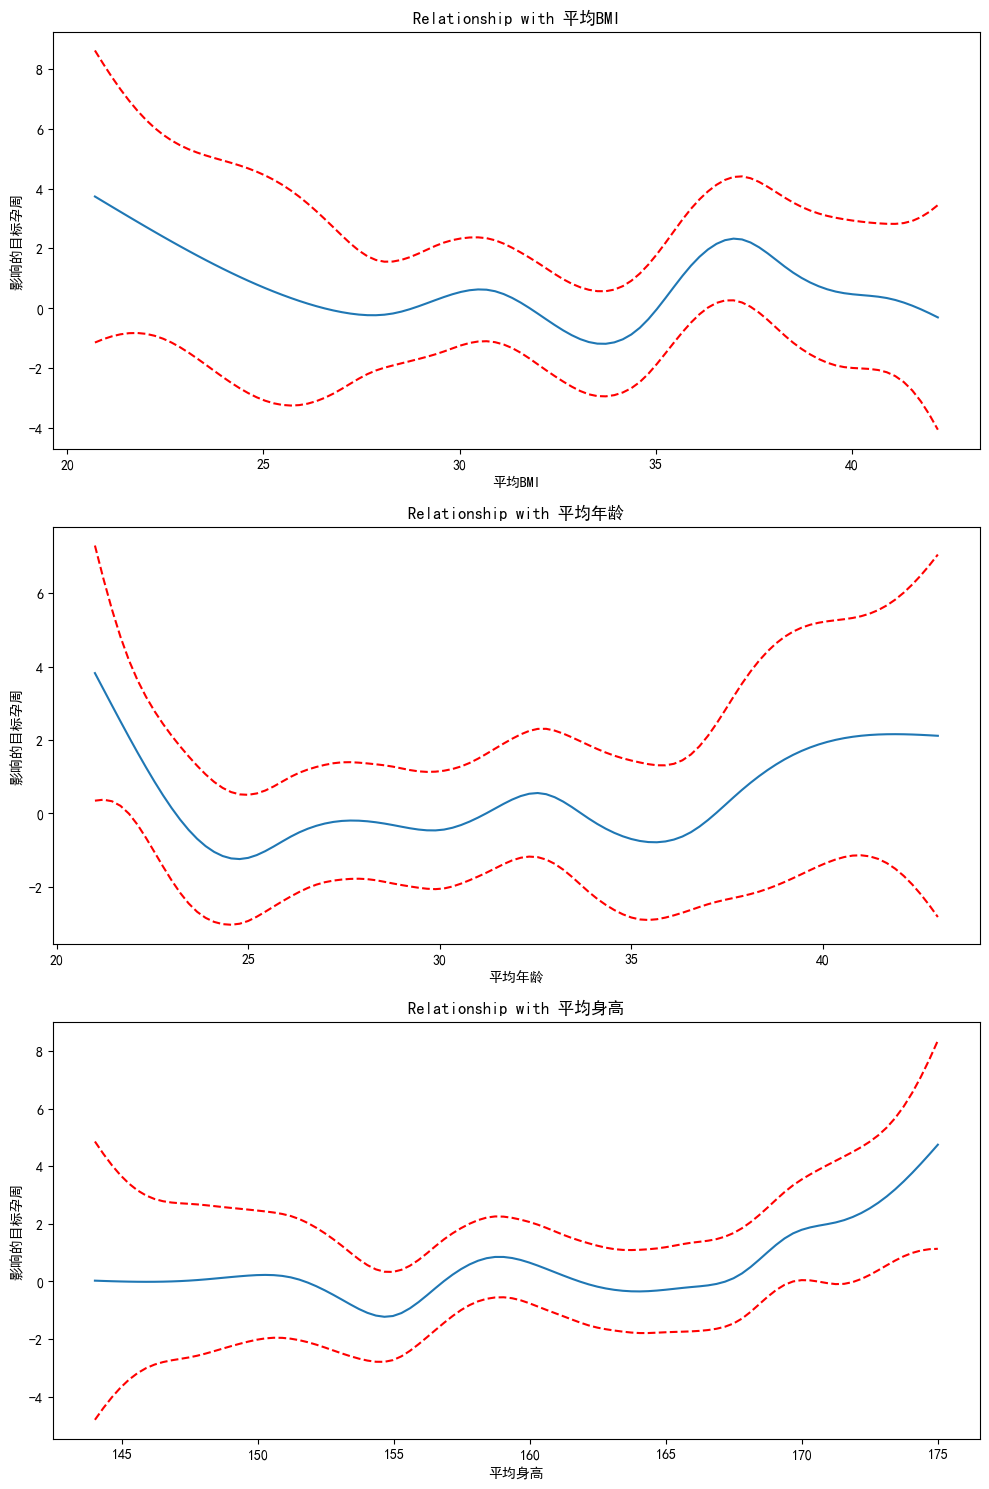

In [126]:
import pandas as pd
from pygam import LinearGAM, s
import matplotlib.pyplot as plt

# Assuming results_df is already defined as per your sample code

# Define the features and target variable
X = results_df[['平均BMI', '平均年龄', '平均身高']]
y = results_df['目标孕周']

# Initialize and fit the GAM model
gam = LinearGAM(s(0) + s(1) + s(2))
gam.fit(X_cleaned, y_cleaned)

# Display summary of the fitted model
print(gam.summary())

# Create a grid for plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plotting for each feature
for i, ax in enumerate(axs):
    feature_name = X.columns[i]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(f'Relationship with {feature_name}')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('影响的目标孕周')

plt.tight_layout()
plt.show()


c:\Users\xia\anaconda3\envs\MCM\Lib\site-packages\pygam\utils.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  array = array.astype("float")


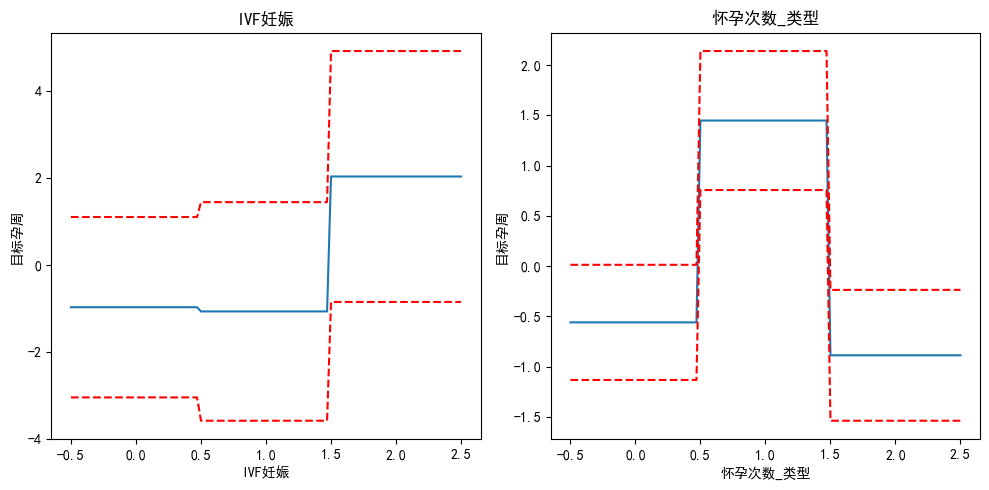

In [127]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, f
import matplotlib.pyplot as plt

# 假设 results_df 已经包含了我们需要的数据
# 删除含有目标孕周为NaN的行
results_df = results_df.dropna(subset=['目标孕周'])

# 确保分类变量是类别类型，并编码
results_df['IVF妊娠'] = results_df['IVF妊娠'].astype('category').cat.codes
results_df['怀孕次数_类型'] = results_df['怀孕次数_类型'].astype('category').cat.codes

# 仅使用分类特征构建GAM模型
gam = LinearGAM(f(0) + f(1)).fit(
    results_df[['IVF妊娠', '怀孕次数_类型']], 
    results_df['目标孕周']
)

# 可视化 GAM 结果
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
titles = ['IVF妊娠', '怀孕次数_类型']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
    ax.set_xlabel(titles[i])
    ax.set_ylabel('目标孕周')

plt.tight_layout()
plt.show()
